# WFIP2/MMC Case: 2016-11-12
Mountain waves were observed between approximately 18-22 UTC on this day.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import timeit

In [2]:
zref = 80.0
starttime = pd.datetime(2016,11,12,0,0,0)
endtime = pd.datetime(2016,11,13,0,0,0)
dt = 10.0 # s
resample_freq = '10S'
t = pd.date_range(start=starttime,end=endtime,freq=resample_freq)

In [3]:
def extract(df,trange,interval=resample_freq):
    return df.loc[trange].resample(interval).interpolate()

## PS-12
Surface Meteorological Station • ANL 80m, Sonic, Physics site-12 • Reviewed Data <br>
wfip2/met.z28.b0: south facing <br>
wfip2/met.z29.b0: west facing

In [4]:
def load_ANL_met_data(pklfile,starttime=pd.datetime(1900,1,1),endtime=pd.datetime.now()):
    time0 = timeit.default_timer()
    df = pd.read_pickle(pklfile)
    daterange = (df.index >= starttime) & (df.index <=endtime)
    df = df.loc[daterange]
    df['u'] = df['Y'] / 100.0 # positive toward east [m/s]
    df['v'] = df['X'] / 100.0 # positive toward north [m/s]
    df['w'] = df['Z'] / 100.0 # positive up [m/s]
    df['theta'] = df['T'] / 100.0 # [deg C]
    df['wind_speed'] = np.sqrt(df['u']**2 + df['v']**2)
    df['wind_direction'] = 180.0/np.pi * (3*np.pi/2 - np.arctan2(df['v'],df['u']))
    df['wind_direction'] = df['wind_direction'].apply(lambda wd: wd if wd < 360.0 else wd-360.0)
    print(f'Processed {len(df)} rows from {pklfile} in {(timeit.default_timer()-time0):.1f} s')
    return df
%time PS12_sonic80s = load_ANL_met_data('/Users/equon/WFIP2/met.z28.b0/met.z28.b0.pkl')
%time PS12_sonic80w = load_ANL_met_data('/Users/equon/WFIP2/met.z29.b0/met.z29.b0.pkl')

Processed 19261404 rows from /Users/equon/WFIP2/met.z28.b0/met.z28.b0.pkl in 11.9 s
CPU times: user 7.54 s, sys: 3.59 s, total: 11.1 s
Wall time: 11.9 s
Processed 19171603 rows from /Users/equon/WFIP2/met.z29.b0/met.z29.b0.pkl in 12.2 s
CPU times: user 7.86 s, sys: 3.55 s, total: 11.4 s
Wall time: 12.2 s


In [5]:
PS12_sonic80s_trange = (PS12_sonic80s.index >= starttime) & (PS12_sonic80s.index <= endtime)
PS12_sonic80w_trange = (PS12_sonic80w.index >= starttime) & (PS12_sonic80w.index <= endtime)

In [7]:
PS12_sonic80s[['wind_speed','wind_direction']].loc[PS12_sonic80s_trange].to_csv('PS12_sonic80s_20161112.csv')
PS12_sonic80w[['wind_speed','wind_direction']].loc[PS12_sonic80w_trange].to_csv('PS12_sonic80w_20161112.csv')

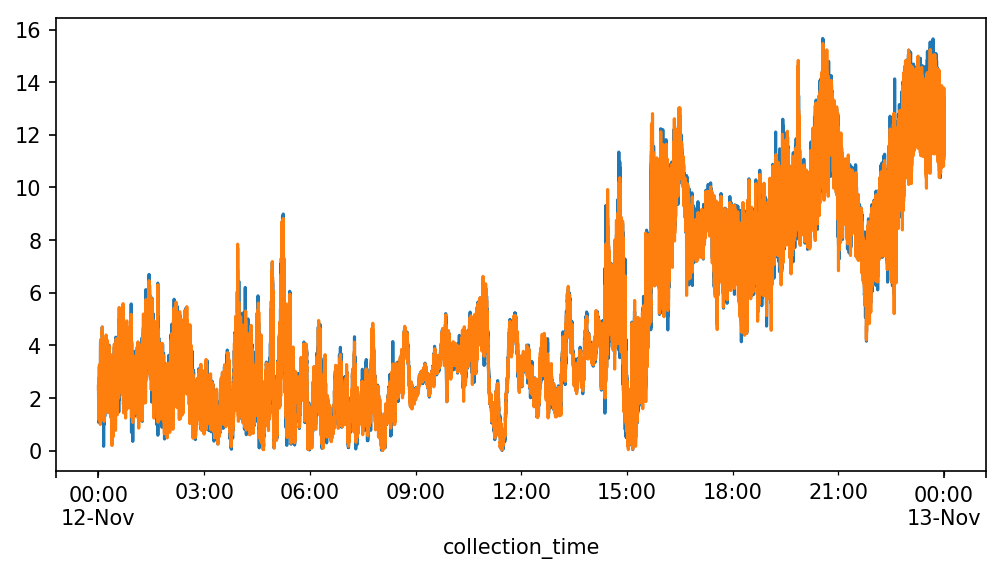

In [8]:
fig,ax = plt.subplots(figsize=(8,4),dpi=150)
PS12_sonic80s['wind_speed'].loc[PS12_sonic80s_trange].plot()
PS12_sonic80w['wind_speed'].loc[PS12_sonic80w_trange].plot()
fig.savefig('wind_speed_20161112.png')

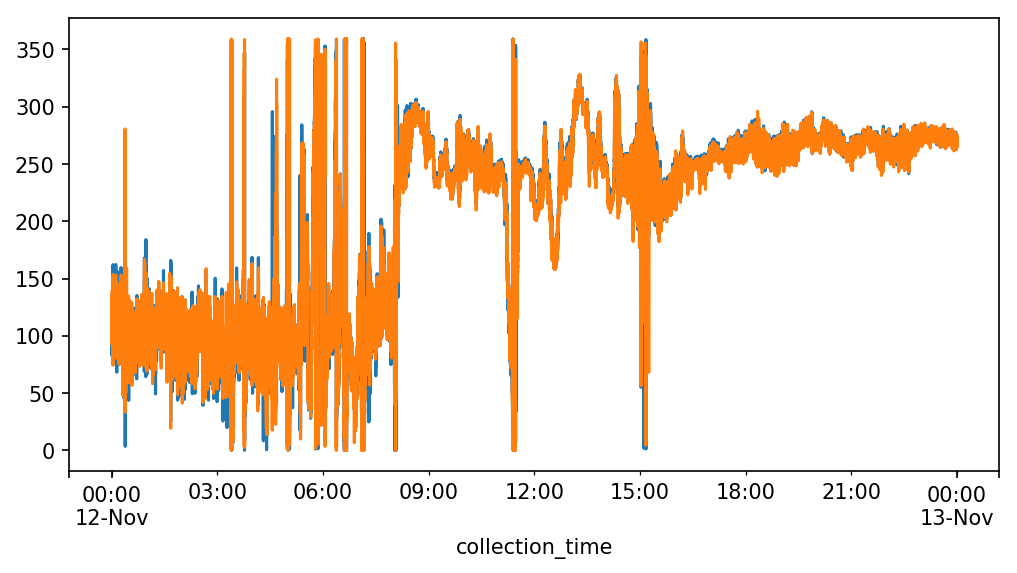

In [9]:
fig,ax = plt.subplots(figsize=(8,4),dpi=150)
PS12_sonic80s['wind_direction'].loc[PS12_sonic80s_trange].plot()
PS12_sonic80w['wind_direction'].loc[PS12_sonic80w_trange].plot()
fig.savefig('wind_direction_20161112.png')

In [ ]:
assert(False)

In [112]:
PS12_sonic80s_windspeed = extract(PS12_sonic80s['wind_speed'],PS12_sonic80s_trange).values
PS12_sonic80w_windspeed = extract(PS12_sonic80w['wind_speed'],PS12_sonic80w_trange).values

## wfip2/lidar.z03.b0
Lidar • CU WindCube V1 Profiler, Wasco Airport • Reviewed Data <br>
<i>Note: These data were received directly from Julie Lundquist rather than downloaded from the DAP</i>

In [113]:
def read_CU_lidar(fname):
    scaninfo = dict()
    with open(fname,'r') as f:
        Nheader = int(f.readline().split('=')[-1])
        for ihdr in range(Nheader):
            line = f.readline()
            if '=' in line:
                paramVal = line.strip().split('=')
                try:
                    ival = int(paramVal[1])
                    scaninfo[paramVal[0]] = ival # integer
                except ValueError: 
                    try:
                        fval = float(paramVal[1]) 
                        scaninfo[paramVal[0]] = fval # float
                    except ValueError:
                        scaninfo[paramVal[0]] = paramVal[1] # string    

        outputs = ["Date","Time"] + f.readline().split()[1:] # assume first column is "Date" which actuatlly corresponds to two columns, date and time
        print('Number of output columns:',len(outputs))

        df = pd.read_table(f,
                           delim_whitespace=True,
                           names=outputs,
                           parse_dates=[['Date', 'Time']],
                           dayfirst=True)
    return df.set_index('Date_Time'), scaninfo

In [114]:
Wasco_lidar, Wasco_scan_info = read_CU_lidar('/Users/equon/WFIP2/Wasco/WLS7-0068_2016_11_12__00_00_00_utf8.sta')

Number of output columns: 184


/Users/equon/miniconda2/envs/python36/lib/python3.6/site-packages/pandas/io/parsers.py:709: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [115]:
Wasco_lidar_trange = (Wasco_lidar.index >= starttime) & (Wasco_lidar.index <= endtime)

In [116]:
Wasco_height = [ float(z) for z in Wasco_scan_info['Altitudes(m)'].strip().split('\t') ]
print('Heights:',Wasco_height)
iref = np.argmin(np.abs(np.array(Wasco_height)-zref))
print('Nearest to zref is',Wasco_height[iref])

Heights: [40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0, 200.0, 220.0]
Nearest to zref is 80.0


In [117]:
U = extract(Wasco_lidar['um'+str(iref+1)],Wasco_lidar_trange)
V = extract(Wasco_lidar['vm'+str(iref+1)],Wasco_lidar_trange)
W = extract(Wasco_lidar['wm'+str(iref+1)],Wasco_lidar_trange)
UH = np.sqrt(U*U + V*V)

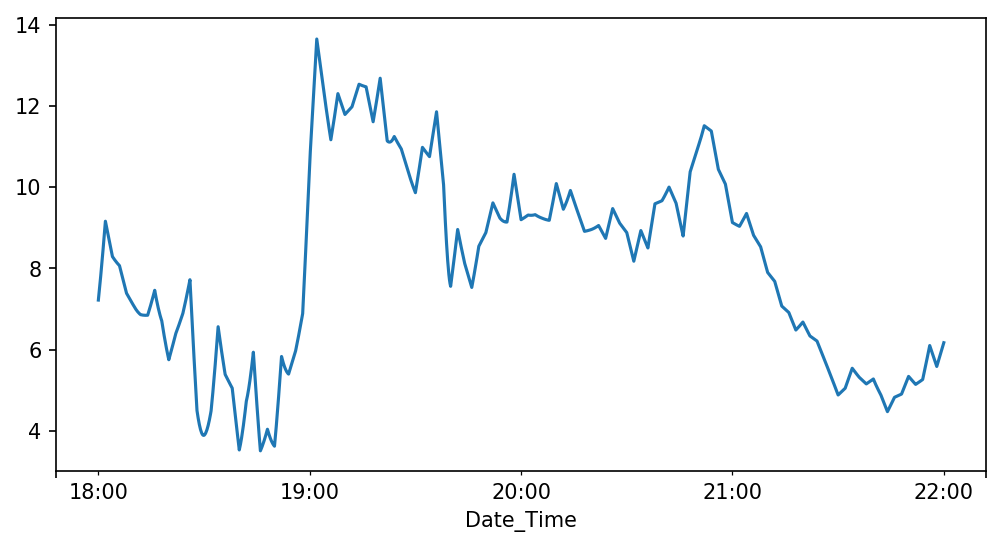

In [118]:
fig,ax = plt.subplots(figsize=(8,4),dpi=150)
UH.plot()

In [119]:
Wasco_lidar_windspeed = UH.values

## wfip2/z02.b0
Lidar • CU WindCube V2 Profiler, Gordons Ridge • Reviewed Data

## wfip2/sodar.z10.b0
Sodar • NREL Scintec MFAS Wind Profiler, Decker Ranch Airstrip • Reviewed Data

## wfip2/radar.z03.b0
Radar • ESRL Wind Profiler with RASS, Prineville • Reviewed Data

In [ ]:
# ONLY 1 snapshot per hour?!

## wfip2/sodar.z04.b0
Sodar • ARL Wind Profiler, Prineville • Reviewed Data

In [ ]:
# ONLY 15 min resolution

## wfip2/sodar.z02.b0
Sodar • Vaisala Triton Wind Profiler, AON7 • Reviewed Data

In [1]:
# NO DATA COLLECTED ON THIS DATE

## wfip2/lidar.z05.b0
Lidar • ESRL WindCube 200s, Arlington Airport • Reviewed Data

In [12]:
def read_ESRL_lidar(fname):
    from netCDF4 import Dataset
    lidar = Dataset(fname)
    #t = lidar.variables['time'][:]
    #h = lidar.variables['height'][:]
    #U = lidar.variables['wind_speed'][:]
    print(lidar)
    return lidar

In [13]:
lidar = read_ESRL_lidar('/Users/equon/WFIP2/Arlington/lidar.z05.b0.20161101.000000.windprof.nc.a2e.nc')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2017-12-19 23:34:12 created by libingest-1.2 using wfip2_lidar-1.3 (build version: v1.9.0)
    dimensions(sizes): time(2235), height(123), bounds(2)
    variables(dimensions): float64 time(time), float64 time_bounds(time,bounds), float32 height(height), float32 wind_speed(time,height), float32 wind_speed_std(time,height), float32 wind_direction(time,height), float32 wind_direction_std(time,height), float64 latitude(), float64 longitude(), float64 altitude()
    groups: 



In [36]:
t = lidar.variables['time'][:]
(t[0], t[-1], t[1]-t[0], np.mean(np.diff(t)))

(75375.0, 2581549.0, 678.0, 1121.832587287377)

In [29]:
Arlington_height = lidar.variables['height'][:]
iref = np.argmin(np.abs(np.array(Arlington_height)-zref))
print('Nearest to zref is',Arlington_height[iref])

Nearest to zref is 80.5797


In [30]:
Arlington_lidar_windspeed = lidar.variables['wind_speed'][:][:,iref]

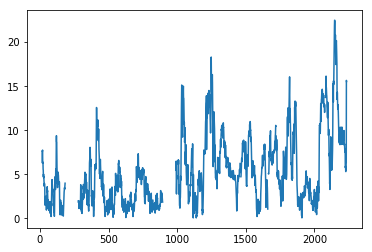

In [31]:
plt.plot(Arlington_lidar_windspeed)

## WRF line samples through Wasco
time: 20:00 UTC <br>
received from Caroline on 2018-02-22 <br>
downloaded from /home/cdraxl/working/wrf_wfip2/wind_line_*.txt

In [167]:
d01 = pd.read_csv('/Users/equon/WFIP2/WRF/2016111206/line_samples/wind_line_3km.txt',delim_whitespace=True)
d02 = pd.read_csv('/Users/equon/WFIP2/WRF/2016111206/line_samples/wind_line_750m.txt',delim_whitespace=True)

In [168]:
len(d01),len(d02)

(251, 1000)

In [194]:
d01['x'] = np.arange(len(d01))*3.
d02['x'] = np.arange(len(d02))*0.75

Text(0.5,0,'x [km]')

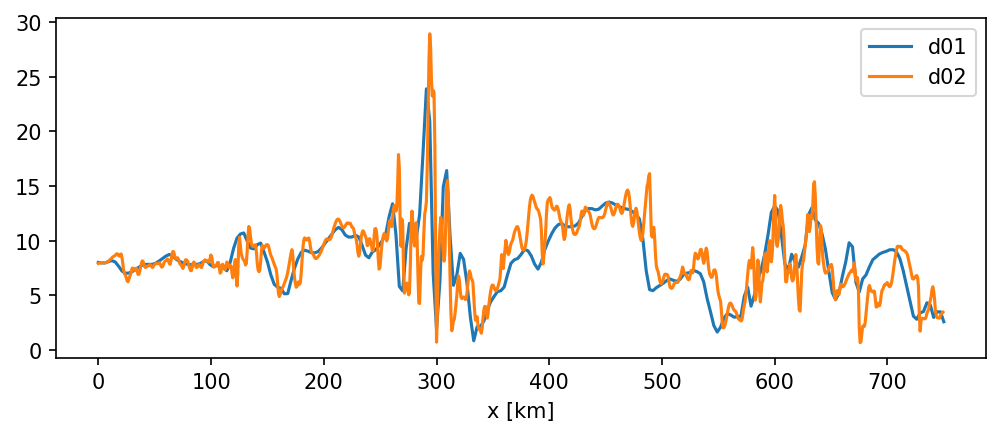

In [195]:
fig,ax = plt.subplots(figsize=(8,3),dpi=150)
d01.plot(ax=ax,x='x',y='speed',label='d01')
d02.plot(ax=ax,x='x',y='speed',label='d02')
ax.set_xlabel('x [km]')

## Comparison of time series

Text(0.5,1,'WFIP2 Measurements, 2016-11-12')

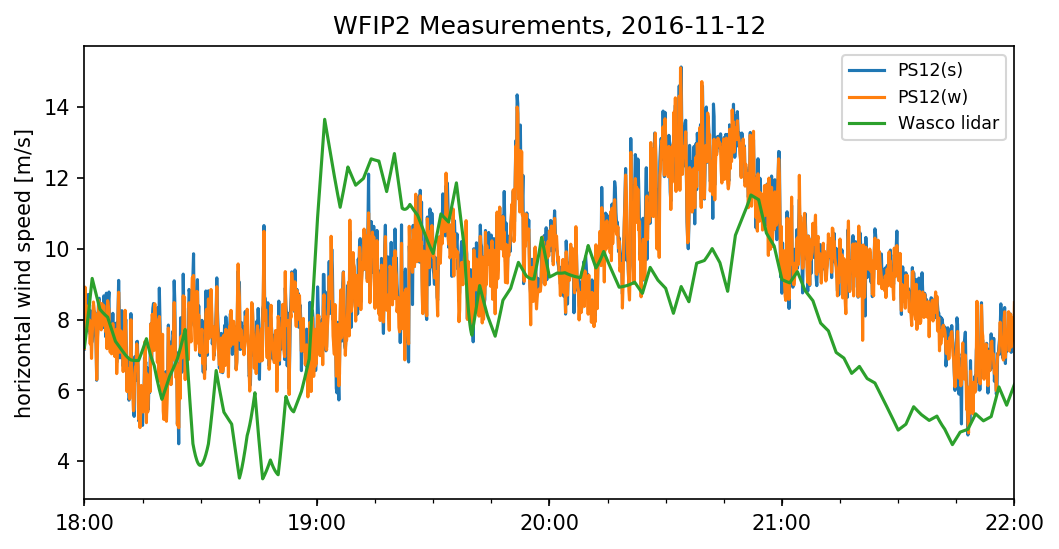

In [124]:
fig,ax = plt.subplots(figsize=(8,4),dpi=150)
ax.plot(t,PS12_sonic80s_windspeed,label='PS12(s)')
ax.plot(t,PS12_sonic80w_windspeed,label='PS12(w)')
ax.plot(t,
        ,label='Wasco lidar')
ax.legend(loc='best',fontsize='small')
hourly = mdates.HourLocator()
every15min = mdates.MinuteLocator(interval=15)
ax.xaxis.set_minor_locator(every15min)
ax.xaxis.set_major_locator(hourly)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(starttime,endtime)
ax.set_ylabel('horizontal wind speed [m/s]')
ax.set_title('WFIP2 Measurements, '+starttime.strftime('%Y-%m-%d'))

## Spectral analysis

In [156]:
sample_list = { 'PS12 80-m sonic (south)': PS12_sonic80s_windspeed,
                'PS12 80-m sonic (west)': PS12_sonic80w_windspeed,
                'Wasco lidar': Wasco_lidar_windspeed,
              }

In [147]:
def calc_fft(u):
    N = len(u)
    Nfft = int(N/2)
    freq = np.fft.fftfreq(N,d=dt) # Hz
    FFT = np.fft.fft(u)
    PSD = np.abs(FFT)**2 / (N*N/dt)  # df==1/dt
    return freq[1:Nfft], PSD[1:Nfft]

(4.9945869105528238e-05, 0.016666666666666666)

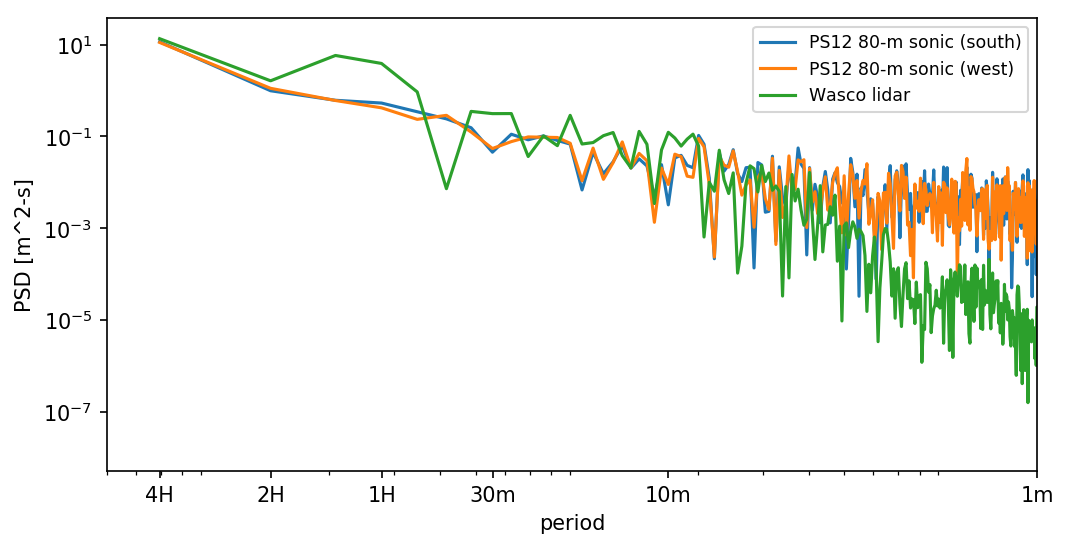

In [157]:
fig,ax = plt.subplots(figsize=(8,4),dpi=150)
for name,u in sample_list.items():
    f,PSD = calc_fft(u)
    ax.loglog(f,PSD,label=name)

ax.set_xlabel('period')
ax.set_xticks((1./14400,1./7200,1./3600,1./1800,1./600,1./60))
ax.set_xticklabels(('4H','2H','1H','30m','10m','1m'))
ax.set_ylabel('PSD [m^2-s]')
ax.legend(loc='upper right',fontsize='small')

xlim = ax.get_xlim()
ax.set_xlim((xlim[0], 1/60.))
#ax.set_ylim((1e-2, 1e8))
